In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
import seaborn as sns

sys.path.append('../../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### ITC DS Patient Hours Recomendation Model

#### Plan is to train boosted tree model with both sfere features
- Random 10% test set
- Train quartile models
    1. with current hrs
    2. without current hrs

In [2]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/itc_sfere_features_20230127.csv', low_memory=False)
print(f'{df.shape[0]} samples')
df.head()

2251 samples


,sfere_id,patient_id,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,15970,12450,8,4,47,2,2,2,2,2,0,0,2,NaN,1,0.0,2.0,1,0,1,2,1,0,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,6.70,5.10
1,30736,12454,8,4,34,0,3,0,0,0,0,0,0,NaN,1,0.0,2.0,0,0,0,0,0,0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,5.06,4.08
2,28597,12455,8,4,56,0,0,0,2,2,0,2,0,NaN,0,NaN,NaN,0,0,1,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,13.62,10.23
3,24393,12458,8,5,29,0,0,0,2,3,2,3,3,NaN,1,2.0,2.0,1,1,1,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,29.37,29.37
4,40385,12459,8,3,46,2,2,2,2,2,0,2,3,NaN,0,NaN,NaN,0,0,2,2,2,2,2,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,35.00,32.42


In [3]:
# filter out 0 recs
# df = df.loc[df.reporting_rec_hrs_tg > 0]
# print(f'{df.shape[0]} samples above 0')

In [4]:
# sum adls iadls
iadls = [
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
]
df = df.assign(total_impairment=df[iadls].sum(axis=1))
df = df.assign(impairment_rank= df['total_impairment'].rank(pct=True),
               cur_hrs_rank=df.reporting_current_hrs_ft.rank(pct=True),
               rec_hrs_rank=df.reporting_rec_hrs_tg.rank(pct=True)
              )

In [5]:
df.head()

,sfere_id,patient_id,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,total_impairment,impairment_rank,cur_hrs_rank,rec_hrs_rank
0,15970,12450,8,4,47,2,2,2,2,2,0,0,2,NaN,1,0.0,2.0,1,0,1,2,1,0,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,6.70,5.10,25.0,0.923145,0.553579,0.539982
1,30736,12454,8,4,34,0,3,0,0,0,0,0,0,NaN,1,0.0,2.0,0,0,0,0,0,0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,5.06,4.08,8.0,0.337850,0.456551,0.466237
2,28597,12455,8,4,56,0,0,0,2,2,0,2,0,NaN,0,NaN,NaN,0,0,1,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,13.62,10.23,11.0,0.533096,0.788158,0.753443
3,24393,12458,8,5,29,0,0,0,2,3,2,3,3,NaN,1,2.0,2.0,1,1,1,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,29.37,29.37,29.0,0.956242,0.981090,0.985784
4,40385,12459,8,3,46,2,2,2,2,2,0,2,3,NaN,0,NaN,NaN,0,0,2,2,2,2,2,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,35.00,32.42,28.0,0.949800,0.989644,0.991781


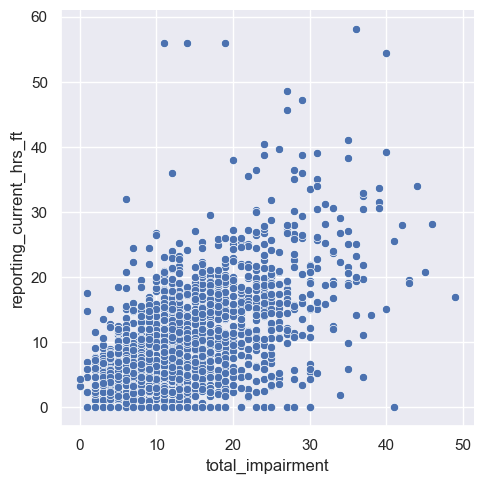

In [6]:
sns.relplot(data=df, x='total_impairment', y='reporting_current_hrs_ft')

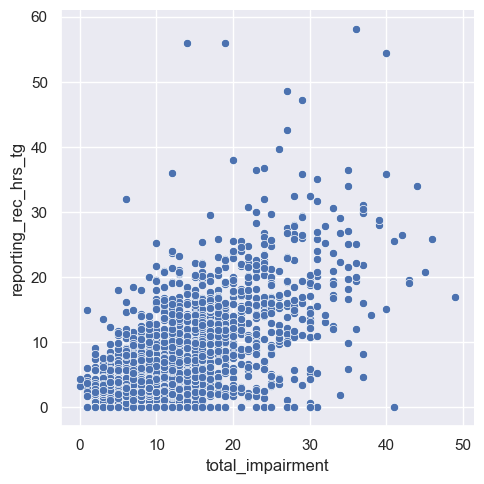

In [7]:
sns.relplot(data=df, x='total_impairment', y='reporting_rec_hrs_tg')

### Features

In [8]:
potential_features = [f for f in df.columns if f.endswith('_ft') and 'grp' not in f]
potential_features 

['payer_id_ft',
 'group_id_ft',
 'age_ft',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'reporting_current_hrs_ft']

In [9]:
categorical_features = [
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'turn_change_position_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'cleaning_ft',
 'laundry_ft',
 'change_bed_ft',
 'clean_kitchen_ft',
 'clean_home_ft',
 'medical_appointments_ft',
 'work_school_socialize_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'group_id_ft'
 # 'is_disabled_ft'
]

cont_features = [
 # 'reporting_current_hrs_ft',
 'age_ft',
]
 

features = categorical_features + cont_features
target = 'reporting_rec_hrs_tg'
categorical_feature_indexes = [i for i in range(len(categorical_features))]

In [10]:
# make sure data always exists
missing_cat = df[categorical_features].count() / df.shape[0]

# features present in < 50% samples
low_freq_feats = [x for x in missing_cat.items() if x[1] <= .5]
low_freq_feats 

[('turn_change_position_ft', 0.0),
 ('cleaning_ft', 0.0),
 ('laundry_ft', 0.0),
 ('change_bed_ft', 0.0),
 ('clean_kitchen_ft', 0.0),
 ('clean_home_ft', 0.0),
 ('medical_appointments_ft', 0.0),
 ('work_school_socialize_ft', 0.0)]

In [11]:
# Likely want to drop low frequency features in categorical vars
lf_feats = [lff[0] for lff in low_freq_feats]
features = [f for f in features if f not in lf_feats]
features

['transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'group_id_ft',
 'age_ft']

In [12]:
new_categorical_feature_indexes = categorical_feature_indexes[:-len(low_freq_feats)]
len(features) - len(new_categorical_feature_indexes) == len(cont_features)

True

### Train Test Split

In [13]:
test_pct = 0.1

patient_ids = df.patient_id.unique().tolist()
test_df_patient_ids = random.sample(patient_ids, int(df.shape[0]*test_pct))

test_df = df.loc[df.patient_id.isin(test_df_patient_ids)]
training_df = df.loc[~df.patient_id.isin(test_df_patient_ids)]

print(f'{test_df.shape[0]} test samples, for {len(test_df_patient_ids)} unique patients')
print(f'{training_df.shape[0]} training samples, for {training_df.patient_id.unique().shape[0]} unique patients')

230 test samples, for 225 unique patients
2021 training samples, for 1999 unique patients


### validate data splits

In [14]:
test_df[target].describe()

count    230.000000
mean       6.296391
std        6.700868
min        0.000000
25%        2.002500
50%        3.910000
75%        8.450000
max       32.000000
Name: reporting_rec_hrs_tg, dtype: float64

In [15]:
training_df[target].describe()

count    2021.000000
mean        7.203506
std         7.281647
min         0.000000
25%         2.300000
50%         4.600000
75%        10.520000
max        58.160000
Name: reporting_rec_hrs_tg, dtype: float64

<AxesSubplot:>

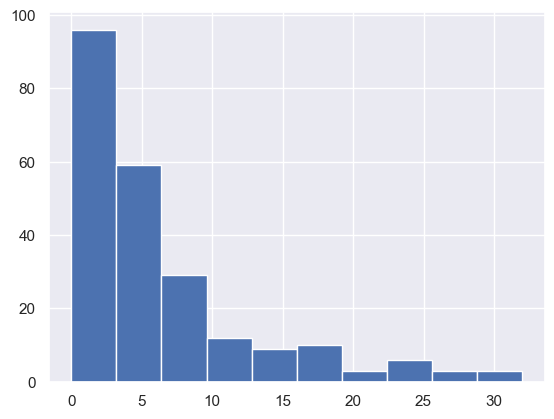

In [16]:
test_df[target].hist()

<AxesSubplot:>

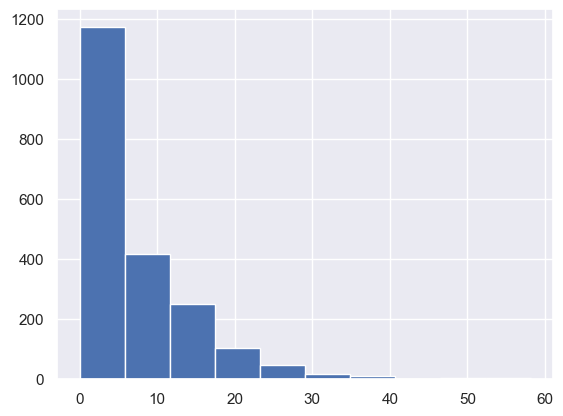

In [17]:
training_df[target].hist()

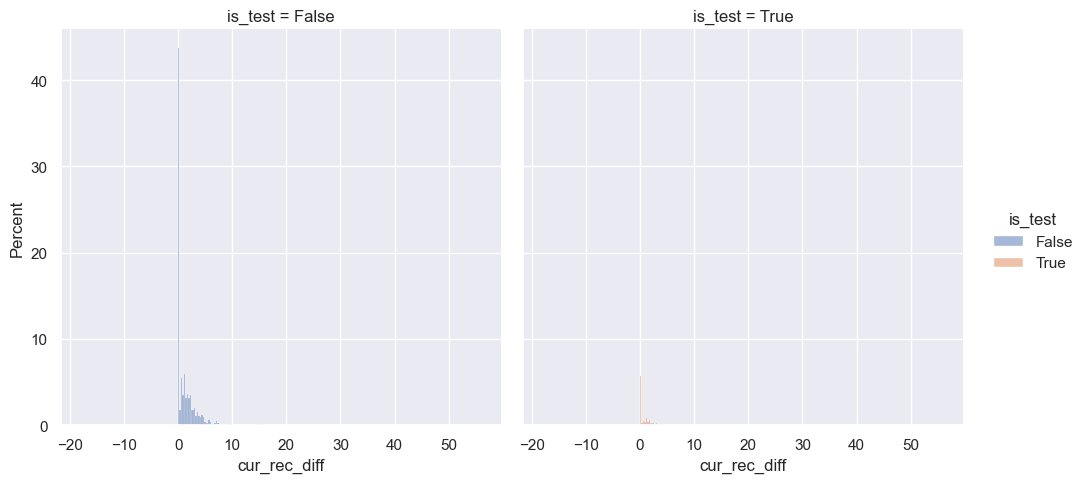

In [18]:
plt_df = df.assign(is_test=df.patient_id.isin(test_df_patient_ids), cur_rec_diff=df.reporting_current_hrs_ft - df.reporting_rec_hrs_tg)
# plt_df.cur_rec_diff.hist(bins=100)
sns.displot(plt_df, x='cur_rec_diff', col='is_test', hue='is_test', stat='percent')

### Training

In [19]:
x_train = training_df[features]
y_train = training_df[target]
x_test = test_df[features]
y_test = test_df[target]

aa_est = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

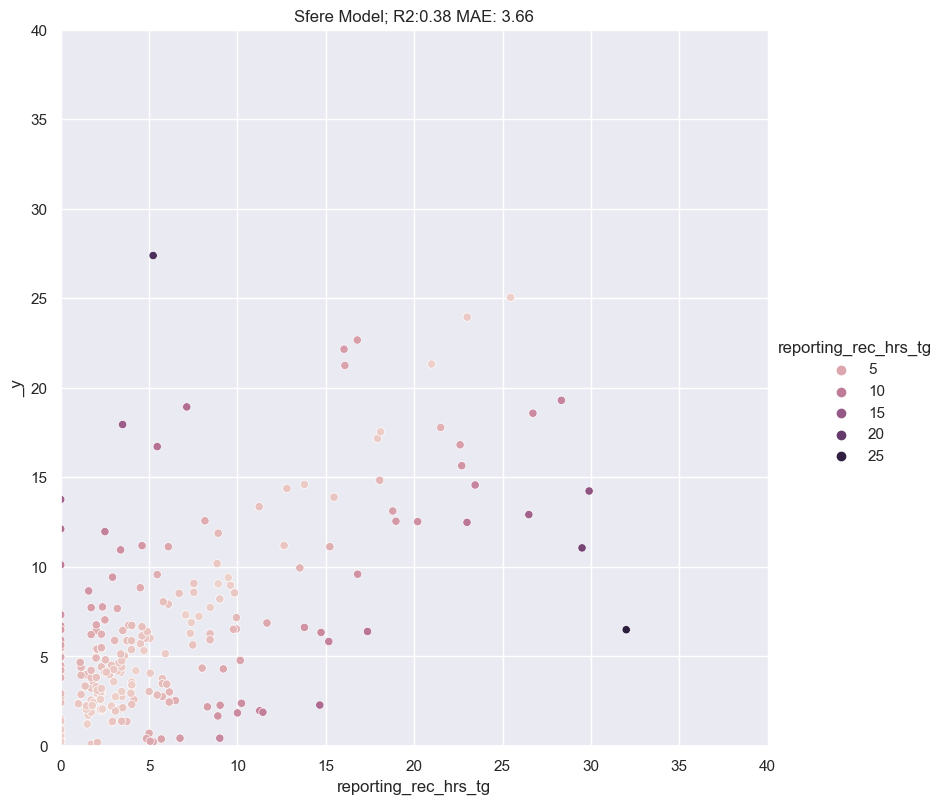

In [20]:
aa_preds = aa_est.predict(x_test)

# preds vs rec
ax = sns.relplot(x=y_test, y=aa_preds, height=8, hue=np.abs(y_test - aa_preds))
ax.set(ylim=(0, 40))
ax.set(xlim=(0, 40))
ax.set(title=f'Sfere Model; R2:{aa_est.score(x_test, y_test):.02f} MAE: {np.mean(np.abs(y_test - aa_preds)):.02f}');
plt.show()


In [21]:
print(f'Feature importances')
r = permutation_importance(aa_est, x_train, y_train,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features.append(features[i])
        print(f"{features[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")

Feature importances
age_ft   0.255  +/- 0.008
group_id_ft 0.107  +/- 0.007
transportation_ft 0.099  +/- 0.004
toileting_ft 0.096  +/- 0.004
grooming_ft 0.088  +/- 0.004
meal_prep_ft 0.073  +/- 0.003
dressing_ft 0.072  +/- 0.003
transfer_bed_to_chair_ft 0.069  +/- 0.002
finances_ft 0.068  +/- 0.003
shopping_ft 0.059  +/- 0.003
medication_management_ft 0.057  +/- 0.002
calling_friends_and_family_ft 0.050  +/- 0.003
bathing_ft 0.048  +/- 0.002
mobility_ft 0.048  +/- 0.002
housework_ft 0.045  +/- 0.002
member_opinion_ft 0.040  +/- 0.002
eating_ft 0.036  +/- 0.002
incontinence_type_ft 0.033  +/- 0.002
incontinence_frequency_ft 0.028  +/- 0.001
transfer_chair_to_standing_ft 0.027  +/- 0.001
comprehension_ft 0.025  +/- 0.002
alert_oriented_day_time_ft 0.015  +/- 0.001
driving_ft 0.011  +/- 0.001
daily_routine_decisions_ft 0.010  +/- 0.001
alert_oriented_place_ft 0.005  +/- 0.000
has_incontinence_ft 0.004  +/- 0.000
has_dementia_ft 0.004  +/- 0.000
articulating_needs_ft 0.003  +/- 0.000
alert_

In [22]:
# quantile model
# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9

lower_model = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                            loss="quantile",
                                            quantile=LOWER_ALPHA
                                           ).fit(x_train, y_train)

upper_model = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                            loss="quantile",
                                            quantile=UPPER_ALPHA
                                           ).fit(x_train, y_train)

l_preds = lower_model.predict(x_test)
h_preds = upper_model.predict(x_test)
np.mean(h_preds - l_preds)

7.947284200797298

### Add in current hrs

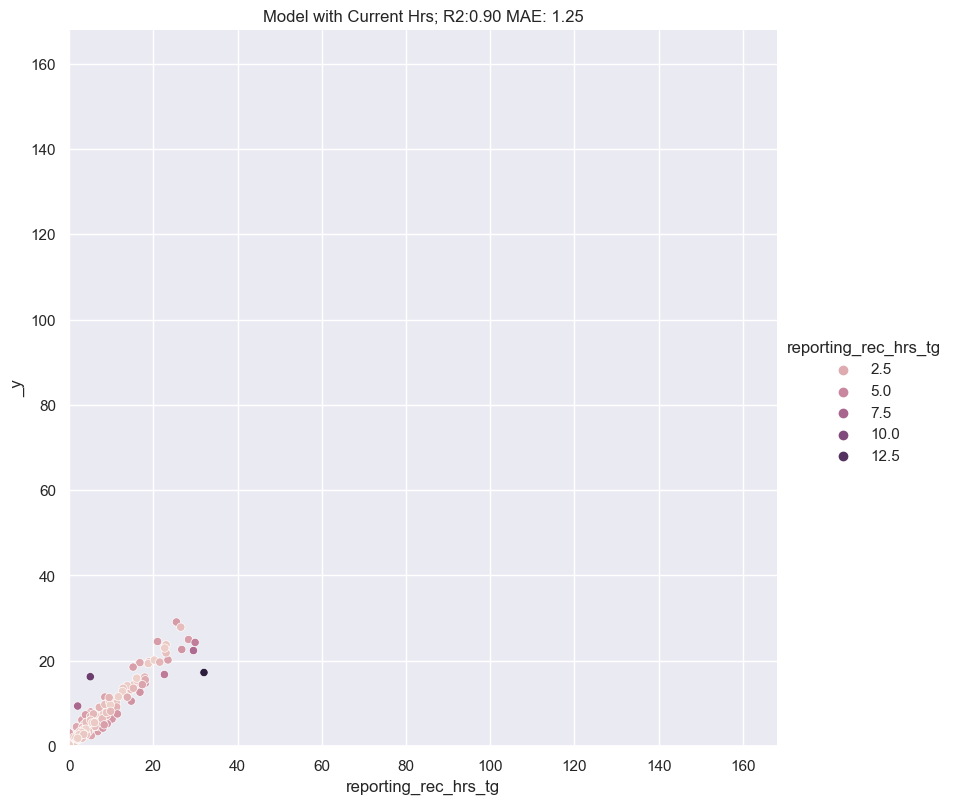

Feature importance with current hrs
reporting_current_hrs_ft 1.640  +/- 0.047
age_ft   0.036  +/- 0.002
group_id_ft 0.016  +/- 0.002
bathing_ft 0.009  +/- 0.001
transfer_chair_to_standing_ft 0.009  +/- 0.001
meal_prep_ft 0.008  +/- 0.000
transportation_ft 0.008  +/- 0.000
transfer_bed_to_chair_ft 0.005  +/- 0.000
finances_ft 0.005  +/- 0.000
grooming_ft 0.005  +/- 0.000
incontinence_type_ft 0.005  +/- 0.000
daily_routine_decisions_ft 0.004  +/- 0.001
incontinence_frequency_ft 0.004  +/- 0.000
medication_management_ft 0.004  +/- 0.000
housework_ft 0.004  +/- 0.000
dressing_ft 0.003  +/- 0.000
eating_ft 0.003  +/- 0.000
shopping_ft 0.003  +/- 0.000
toileting_ft 0.003  +/- 0.000
mobility_ft 0.003  +/- 0.000
comprehension_ft 0.002  +/- 0.000
member_opinion_ft 0.002  +/- 0.000
has_incontinence_ft 0.001  +/- 0.000
driving_ft 0.001  +/- 0.000
calling_friends_and_family_ft 0.001  +/- 0.000
alert_oriented_day_time_ft 0.001  +/- 0.000
articulating_needs_ft 0.000  +/- 0.000
has_dementia_ft 0.000 

In [23]:
# can add to end b/c continuous features are always last after cat feats
features_w_cur_hrs = features + ['reporting_current_hrs_ft']

x_train = training_df[features_w_cur_hrs]
y_train = training_df[target]
x_val = test_df[features_w_cur_hrs]
y_val = test_df[target]

aa_est_ch = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                       max_iter=1000).fit(x_train, y_train)

aa_preds_ch = aa_est_ch.predict(x_val)

# preds vs rec
ax = sns.relplot(x=y_val, y=aa_preds_ch, height=8, hue=np.abs(y_val - aa_preds_ch))
ax.set(ylim=(0, 168))
ax.set(xlim=(0, 168))
ax.set(title=f'Model with Current Hrs; R2:{aa_est_ch.score(x_val, y_val):.02f} MAE: {np.mean(np.abs(y_val - aa_preds_ch)):.02f}');
plt.show()

print(f'Feature importance with current hrs')
r = permutation_importance(aa_est_ch, x_train, y_train,
                           n_jobs=-1,
                           n_repeats=50,
                           random_state=0)

best_features_ch = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        best_features_ch.append(features_w_cur_hrs[i])
        print(f"{features_w_cur_hrs[i]:<8} "
              f"{r.importances_mean[i]:.3f} "
              f" +/- {r.importances_std[i]:.3f}")
#

In [24]:
# quantile model
# Set lower and upper quantile

lower_model = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                            loss="quantile",
                                            quantile=LOWER_ALPHA
                                           ).fit(x_train, y_train)

upper_model = HistGradientBoostingRegressor(categorical_features=new_categorical_feature_indexes,
                                            loss="quantile",
                                            quantile=UPPER_ALPHA
                                           ).fit(x_train, y_train)

l_preds_ch = lower_model.predict(x_val)
h_preds_ch = upper_model.predict(x_val)

np.mean(h_preds_ch - l_preds_ch)

2.8101144199375687

In [25]:
out_df = test_df.assign(pred=aa_preds,
                        low_pred=l_preds,
                        high_pred=h_preds,
                        pred_w_current_hrs=aa_preds_ch,
                        low_pred_w_current_hrs=l_preds_ch,
                        high_pred_w_current_hrs=h_preds_ch
                       )
out_df = out_df.assign(in_range=(out_df.reporting_rec_hrs_tg >= out_df.low_pred) & (out_df.reporting_rec_hrs_tg <= out_df.high_pred),
                       in_range_w_cur_hrs=(out_df.reporting_rec_hrs_tg >= out_df.low_pred_w_current_hrs) & (out_df.reporting_rec_hrs_tg <= out_df.high_pred_w_current_hrs))
out_df.head()

,sfere_id,patient_id,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,total_impairment,impairment_rank,cur_hrs_rank,rec_hrs_rank,pred,low_pred,high_pred,pred_w_current_hrs,low_pred_w_current_hrs,high_pred_w_current_hrs,in_range,in_range_w_cur_hrs
2,28597,12455,8,4,56,0,0,0,2,2,0,2,0,NaN,0,NaN,NaN,0,0,1,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,13.62,10.23,11.0,0.533096,0.788158,0.753443,2.385648,1.737542,9.499314,10.573330,8.305900,13.625424,False,True
7,28850,12463,8,6,57,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,0.0,0.0,0.0,12.82,8.45,4.0,0.070191,0.771274,0.698801,6.269338,1.728394,8.386943,11.486830,9.169718,12.424791,False,False
16,20370,12500,8,6,47,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,0,1,0,0,1,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,7.47,5.06,5.0,0.124389,0.601306,0.536206,6.013336,1.847219,6.185604,7.995706,3.218021,7.537041,True,True
39,13429,12596,8,4,43,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,7.33,7.33,2.0,0.015104,0.593877,0.657486,6.296623,1.885566,5.086359,6.959398,3.094586,7.515366,False,True
71,31657,12714,8,6,48,0,0,2,0,0,0,0,0,NaN,1,2.0,2.0,1,0,1,1,1,1,2,2,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,7.18,5.46,16.0,0.756108,0.587348,0.562861,9.570636,4.861007,15.402470,6.250683,5.235434,7.948043,True,True


In [26]:
out_df.loc[~out_df.in_range_w_cur_hrs]

,sfere_id,patient_id,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,total_impairment,impairment_rank,cur_hrs_rank,rec_hrs_rank,pred,low_pred,high_pred,pred_w_current_hrs,low_pred_w_current_hrs,high_pred_w_current_hrs,in_range,in_range_w_cur_hrs
7,28850,12463,8,6,57,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,1,0,0,0,1,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,0.0,0.0,0.0,12.82,8.45,4.0,0.070191,0.771274,0.698801,6.269338,1.728394,8.386943,11.486830,9.169718,12.424791,False,False
84,11276,12754,8,6,48,0,0,0,2,2,0,0,0,NaN,0,NaN,NaN,0,0,1,2,1,0,0,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,13.53,13.53,11.0,0.533096,0.785232,0.832519,9.943305,0.000014,9.611947,13.041644,8.256876,13.464726,False,False
113,33646,12838,8,6,64,0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0,0,1,1,0,0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,5.75,5.75,5.0,0.124389,0.498874,0.580187,3.758712,1.332870,6.407373,3.188781,3.083193,5.671424,True,False
154,16326,12964,8,4,60,0,0,0,0,0,0,0,0,NaN,1,2.0,2.0,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,1.10,0.00,6.0,0.193914,0.101981,0.051311,0.452755,0.000014,3.107346,0.760374,0.567265,1.169976,False,False
157,15254,12973,8,4,47,2,2,2,2,2,1,0,2,NaN,0,NaN,NaN,1,0,0,1,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,0.00,0.00,16.0,0.756108,0.047726,0.051311,0.320710,0.000014,11.995654,-0.463076,0.000014,1.090533,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2119,15958,23448,8,7,80,0,0,0,0,1,0,2,0,NaN,0,NaN,NaN,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,0.00,0.00,4.0,0.070191,0.047726,0.051311,1.389722,0.000014,5.388495,0.457695,0.000014,1.784621,False,False
2151,16992,23517,8,7,76,0,0,0,0,2,0,2,0,NaN,1,0.0,0.0,0,0,1,0,0,0,1,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,8.30,8.30,9.0,0.406486,0.638451,0.695913,2.186327,1.306079,8.502228,4.958366,3.223562,8.011562,True,False
2158,18338,23538,8,7,72,0,0,0,0,0,0,0,0,NaN,1,0.0,0.0,0,0,1,0,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,0.00,0.00,4.0,0.070191,0.047726,0.051311,0.912654,0.000014,6.518411,0.247810,0.000014,0.196663,False,False
2171,41649,23567,8,7,68,0,0,0,2,2,0,2,0,NaN,0,NaN,NaN,0,0,1,1,0,1,2,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,NaN,0.0,17.36,17.36,14.0,0.689916,0.875281,0.911151,6.395242,3.337185,12.237820,14.383545,12.612607,16.673476,False,False


In [27]:
# out_df.to_csv('../data/itc_test_set_model_results_20230127.csv', index=False)

### Prep for Sagemaker Training/Deploy
Format: target in col one, then features 

Will make the current hrs feature last so that it is easy to remove

In [33]:
ordered_cols = ['reporting_rec_hrs_tg'] + features + ['reporting_current_hrs_ft']
ordered_cols

['reporting_rec_hrs_tg',
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'group_id_ft',
 'age_ft',
 'reporting_current_hrs_ft']

In [29]:
training_data_file = '../data/itc_training_data_20230127.csv'
df[['reporting_rec_hrs_tg'] + features + ['reporting_current_hrs_ft']].to_csv(training_data_file, index=False, header=False)

In [31]:
import boto3
from time import gmtime, strftime

In [32]:
s3 = boto3.client('s3')

bucket = 'cb-analytics-us-east-2-prd'
prefix = 'sagemaker/training_data'
key = f'{prefix}/{strftime("%Y%m%d%H%M%S", gmtime())}_itc_traning_data.csv'

s3.upload_file(training_data_file, bucket, key, ExtraArgs={'ServerSideEncryption': 'AES256'})
key

'sagemaker/training_data/20230127201843_itc_traning_data.csv'

### Sagemaker Training
Broken out into separate notebook that needs to be run on a sagemaker notebook instance in the aws console

In [ ]:
raise "Stop"

In [ ]:
# TODO clean up the following pulled from previous NB

### Patient Similarity model
- Find the k (in this case 10) most similar patients to a single patient within the context of the payer
- Can compare signle patient to mean/median min/max of 10 "neighbors"
- Can also look at the 10 neighbors, see how they are similar

In [34]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.preprocessing import RobustScaler
# X = [[ 1., -2.,  2.],
#      [ -2.,  1.,  3.],
#      [ 4.,  1., -2.]]
# transformer = RobustScaler().fit(X)
# transformer

# transformer.transform(X)

#### These are the dimensions over which we calc similarity
Currently just adls and age

In [35]:
features

['transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'group_id_ft',
 'age_ft']

In [42]:
df.group_id_ft.value_counts()

7    1709
6     187
4     161
3      84
5      35
2      28
1      28
0      15
8       3
9       1
Name: group_id_ft, dtype: int64

In [41]:
neighbors = {}
k = 100

x_train = df[[f for f in features if f != 'group_id_ft']

pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('scaler', preprocessing.RobustScaler())])
pipe.fit(x_train)
x = pipe.transform(x_train)
nn = NearestNeighbors(n_neighbors=k).fit(x)
distances, nn_idxs = nn.kneighbors()

# get patient_ids
for i, nn_idx in enumerate(nn_idxs): 
    neighbors[df.iloc[i].patient_id] = df.iloc[nn_idx].patient_id.values

In [ ]:
rows = []
for pid in df.patient_id.unique():
    pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
    p = df.loc[df.patient_id == pid]
    
    rows.append([pid, p.reporting_rec_hrs.mean(), pid_neighbors.reporting_rec_hrs.mean(), pid_neighbors.reporting_rec_hrs.median(), pid_neighbors.reporting_rec_hrs.min(), pid_neighbors.reporting_rec_hrs.max()])
nn_df = pd.DataFrame(rows, columns=['patient_id', 'rec_hrs', 'mean_nn', 'median_nn', 'min_nn', 'max_nn']) 
nn_df.head()

In [ ]:
# calc ranges and mean abs error
nn_df = nn_df.assign(exact_in_range=np.where((nn_df.rec_hrs >= nn_df.min_nn) & (nn_df.rec_hrs <= nn_df.max_nn), 1, 0),
                     hrs_range=nn_df.max_nn - nn_df.min_nn,
                     in_range=np.where((nn_df.rec_hrs - nn_df.min_nn > -1) & (nn_df.rec_hrs - nn_df.max_nn < 1), 1, 0))

nn_df = nn_df.assign(mean_err=np.abs(nn_df.mean_nn - nn_df.rec_hrs), median_err=np.abs(nn_df.median_nn - nn_df.rec_hrs))

In [ ]:
nn_df.head()

In [ ]:
print(f'Percent rec hrs in neighbors range: {nn_df.in_range.sum() * 100 / nn_df.shape[0]}')
print(f'Percent rec hrs in exact neighbors range: {nn_df.exact_in_range.sum() * 100 / nn_df.shape[0]}')

In [ ]:
nn_df.describe()

### Check random patient's neighbors
In practice could show top 10 most similar patients

In [ ]:
pid = nn_df.patient_id.sample().values[0]
pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
print(f'Patient id {pid}, neighbor mean/range: {pid_neighbors.reporting_rec_hrs.mean()}; {pid_neighbors.reporting_rec_hrs.min()} - {pid_neighbors.reporting_rec_hrs.max()}')
pid_neighbors 